# ***Voorspellen van Verhuuraantallen*** 

Teamleden:
- Busse Heemskerk
- Declan van den Hoek
- Isa Dijkstra

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om diabetes te voorspellen. Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning), om makkelijk de bestanden te delen.

## ***Inhoudsopgave*** <a name='begin'></a>

1. [H1: Explorative Data Analysis](#h1)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_test = pd.read_csv('test.csv', sep = ',')
data_train = pd.read_csv('train.csv', sep = ',')

In [47]:
data_train.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


## **H1: Explorative Data Analysis**<a name='h1'></a>

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen.

In [48]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [49]:
data_train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### ***Time-Series visualisaties***

Eerst zullen er de benodigde functies worden aangemaakt, om op die manier gemakkelijk de verschillende nieuwe time-series kolommen aan te maken.

In [68]:
def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Voeg nieuwe kolommen toe
    df['Jaar'] = df[f'{dt_kol}'].dt.year
    df['Maand'] = df[f'{dt_kol}'].dt.month
    df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week
    df['Uur'] = df[f'{dt_kol}'].dt.hour

    return df

Deze functies zullen helpen om nieuwe kolommen toe te voegen aan data_train, en later ook aan data_test.

In [51]:
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Uur
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,0
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,2
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,3
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,4


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   holiday     16637 non-null  int64         
 2   weathersit  16637 non-null  int64         
 3   temp        16637 non-null  float64       
 4   atemp       16637 non-null  float64       
 5   hum         16637 non-null  float64       
 6   windspeed   16637 non-null  float64       
 7   cnt         16637 non-null  int64         
 8   Jaar        16637 non-null  int32         
 9   Uur         16637 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(2), int64(3)
memory usage: 1.1 MB


### ***Time-Series Visualiseren***

Nu wordt er een class gemaakt die het mogelijk maakt om snel en eenvoudig verschillende grafieken aan te maken.

In [53]:
class Grafieken:
    """
    Een class voor eenvoudig visualiseren met Matplotlib
    en seaborn.

    Parameters:
    ----------
    df : pandas.DataFrame
        Een pandas.DataFrame die data bevat om mee te
        visualiseren.
    """

    def __init__(self, df):
        """
        De constructor voor de Grafieken class

        Parameters:
        ----------
        df : pandas.DataFrame
            Een pandas.DataFrame die data bevat om mee te
            visualiseren.
        """
        # Aanmaken self.df
        self.df = df

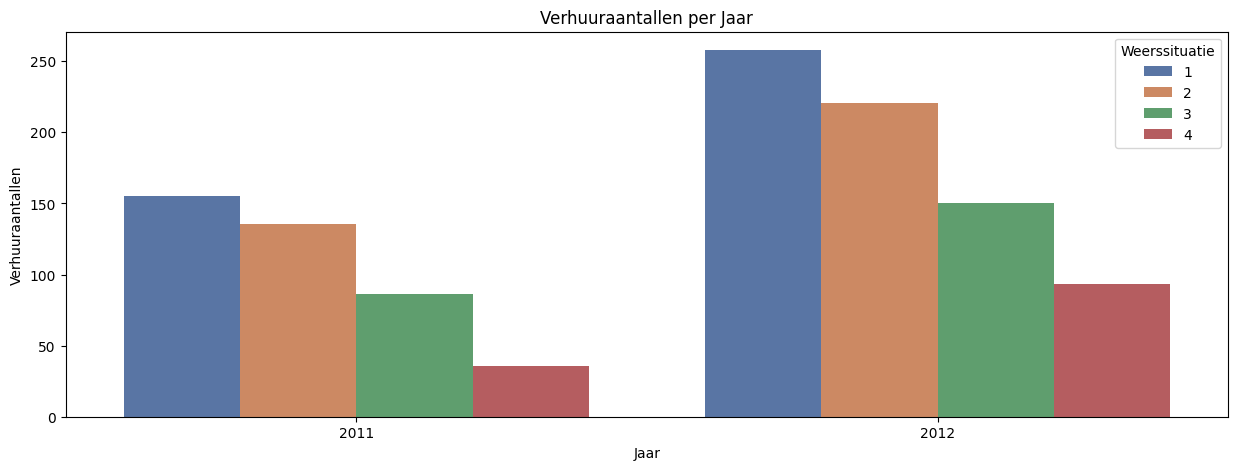

In [54]:
plt.subplots(figsize=(15, 5))
sns.barplot(data=df, x='Jaar', y='cnt',
            hue='weathersit', errorbar=None,
            palette='deep')

plt.title('Verhuuraantallen per Jaar')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Weerssituatie')
plt.show()

Zoals hierboven te zien is, zijn er in 2012 meer verhuursaantallen. Ook is er heel duidelijk te zien dat er een duidelijk verschil is tussen de verschillende weersituaties. Dat de weersomstandigheden een grote invloed hebben is mogelijk als het te verhuren product gebruikt wordt zonder afdekking van regen of andere neerslag.

Bij een weerssituatie van klasse van 1 is er een algemeen hoger verhuur, dit neemt af naarmate je omhoog gaat op de schaal. Hieronder is verduidelijking over de schaal van deze kolom:

**weathersit**:
1. Helder, licht bewolkt, deels bewolkt
2. Mistig , mistig en licht bewolkt
3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte
regen en zwaar bewolkt
4. Zware regen, hagel, zware mist, sneeuw.

Voor verder onderzoek wordt er nu gekeken naar de verdeling van het verhuur per uur.

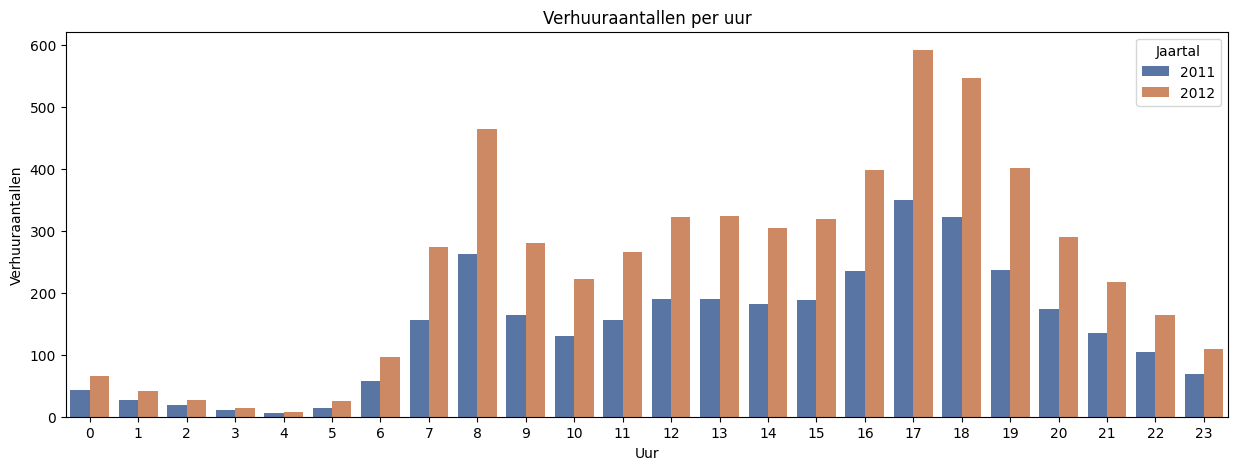

In [55]:
plt.subplots(figsize=(15, 5))
sns.barplot(data=df, x='Uur', y='cnt',
            hue='Jaar', errorbar=None,
            palette='deep')

plt.title('Verhuuraantallen per uur')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Jaartal')
plt.show()

De grafiek over de verhuuraantallen per uur per jaar geeft ook een duidelijke boodschap. Rond de uren van 6 t/m 8 vindt er een sterke stijging plaats, wat niet heel raar is aangezien de meeste mensen tussen 6 en 8 wakker worden. Rond de uren van 17 en 18 is er ook een gigantische piek, dit kan te verklaren zijn door het eindigen van de gemiddelde werkdag.

Ondanks dat de pieken op de spitsuren zitten is het in de tijd van 9 tot en met 16 ook relatief druk qua verhuur. Wat wel opvalt is dat er een duidelijk dalpunt is rond de uren 2 tot en met 5. Met de meeste services zullen producten tussen deze tijd niet meer worden verhuurd, wat ervoor zorgt dat ook dit punt erg opvalt.

Om iets meer inzicht te krijgen over het algemene verhuur gedrag zal deze grafiek nagemaakt worden met boxplots, om zo de verdeling en de outliers ook duidelijk te zien.

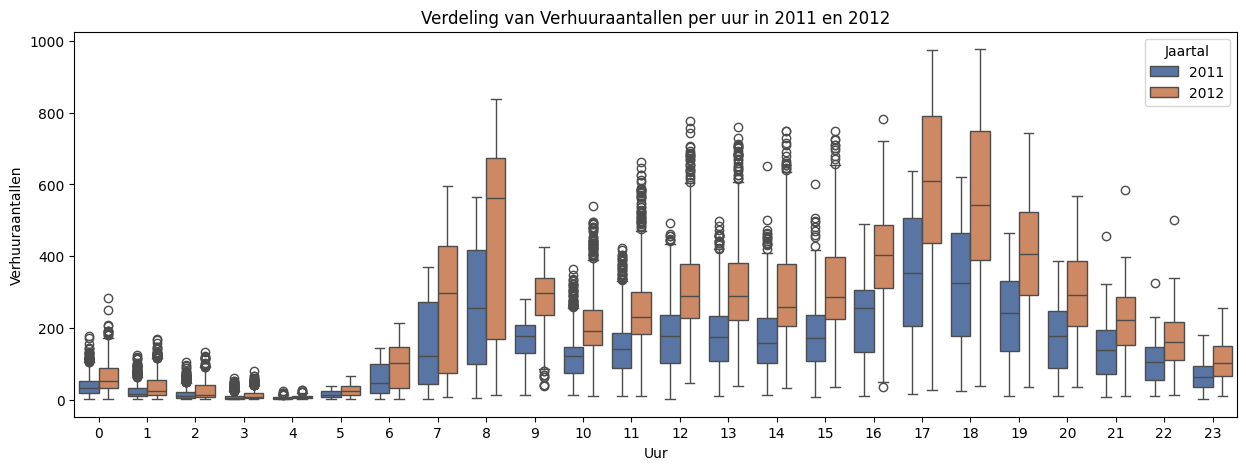

In [56]:
# Aanmaken van plotgrootte en boxplot
plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='Uur', y='cnt',
            hue='Jaar', palette='deep')

# Titel en tonen van de grafiek
plt.title(f'Verdeling van Verhuuraantallen per uur in 2011 en 2012')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Jaartal')
plt.show()

Het voordeel aan boxplots is dat er per waarde op de x-as een verdeling wordt getoond. Deze verdeling laten zien waar het gemiddelde ligt en of er outliers aanwezig zijn. Wat opvalt is de afwezigheid van outliers in de drukste uren van het verhuren. Van de tijden 5 tot en met 8 en de tijden 17 tot en met 20 zijn er geen outliers. Verder is het ook opvallend dat er nauwelijks outliers zijn aan de onderkant van de boxplots.

Naast de outliers valt het ook op dat niet alleen de totale waarden hoger liggen in 2012, maar ook de mediaan van (bijna) alle boxes ligt boven de 75% percentiel van het voorgaande jaar.

Alles bij elkaar zorgt ervoor dat het product uit de transport sector te komen. Met de eerste grafiek is er vanuit te gaan dat deze vorm van transport geen dak of bescherming zal hebben tegen neerslag. De tweede en derde grafiek laten duidelijk zien dat de spitsuren cruciaal zijn voor het verhuurbedrijf. Voor transport is de spitsuren natuurlijk het drukste, wegens alle scholieren en werkende die rond deze tijden actief zijn met het gaan van A naar B. Dit zou een goede verklaring zijn voor hoe de verhuuraantallen reageren op de uren.

Als volgende stap worden de correlaties van alle kolommen bekeken ten opzichte van de target kolom.

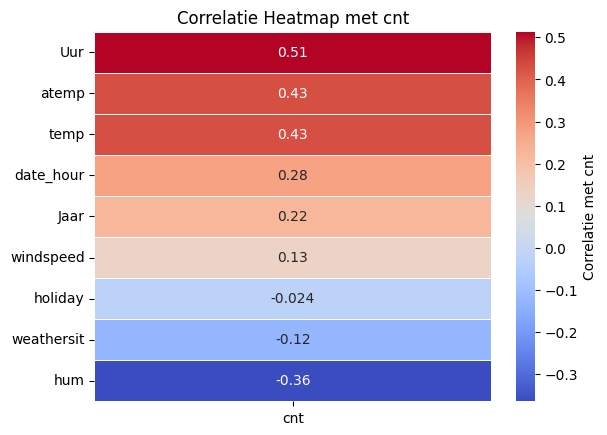

In [57]:
# Correlatie matrix aanmaken
corr = df.corr(method='spearman')

# Aanmaken van target variabel
target = 'cnt'

# Pakken van correlaties target-kolom
corr_target = corr[target].drop(target).sort_values(ascending=False)

# Heatmap maken en aanpassen
sns.heatmap(corr_target.to_frame(target),
            annot=True,
            linewidths=0.4,
            annot_kws={"size" : 10},
            cmap="coolwarm",
            cbar_kws={"label" : f"Correlatie met {target}"})

# Aanpassen titel en tonen heatmap
plt.title(f"Correlatie Heatmap met {target}")
plt.show()


Meerendeel van de tijd series kolommen die erbij zijn gezet hebben geen invloed op de verkoop. De kolom 'Uur' is hierin een uitzondering, met een correlatie van 0.51 is dit de sterkst correlerende kolom van de dataset. Dit is waarschijnlijk neer te leggen op de eerder besproken verwachtingen rondom de spitsuren. Ook de kolommen van temperatuur en vochtigheid correleren redelijk met het verhuuraantal.

In [58]:
df_time = df[['date_hour', 'cnt']]
df_time = df_time.set_index('date_hour')
df_time.head()

,cnt
date_hour,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


---------------

In [59]:
df_test = data_voorbereiding(data_test, 'date_hour')
df_test.drop('date_hour', axis=1, inplace=True)

In [60]:
from sklearn.ensemble import RandomForestRegressor
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [61]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(df_test)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Tonen van de resultaten
    return print(f'Root Mean Squared Error: {rmse}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste RMSE: {abs(gs.best_score_)}")
    print(f"Beste parameters:\n{gs.best_params_}")

In [62]:
# Aanmaken SEED voor random_state
SEED = 42

# Aanmaken van X en y
df_train = df.drop(['date_hour'], axis=1)
X = df_train.drop('cnt', axis=1)
y = df_train['cnt']

# Splitten van de data in train en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Aanmaken van de folds
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

## ***Random Forest Regressor***



In [63]:
# Opstellen van Random Forest Regressor model
rf = RandomForestRegressor(random_state=SEED,
                              n_jobs=-1)

# Beoordelen van het model
model_score(rf)

Root Mean Squared Error: 87.66807740302941


In [64]:
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}


In [65]:
grid_score(rf, param_rf)

Beste RMSE: 89.40388176440138
Beste parameters:
{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}


In [66]:
rf_tuned = RandomForestRegressor(n_estimators=200,
                           max_depth=2,
                           min_samples_leaf=20,
                           random_state=SEED,
                           n_jobs=-1)

model_score(rf_tuned)

Root Mean Squared Error: 137.72975262595605


In [67]:
#submissie(rf, 'RF')

vs_RF_1102135646.csv has been saved!


### **XGBoost**

Als __ keuze model is er gekozen om gebruik te maken van XGBoost Regressor. Dit model heeft enkele voordelen die er toe hebben geleid om dit model te kiezen. Volgens Kumar (2019) is een van de voordelen de regularisatie van een XGBoost model. Dit model bevat zowel Lasso (L1) als Ridge (L2) regularisatie, wat ervoor zorgt dat het model moeilijker overfit. Via de Scikit Learn libary is het mogelijk om verschillende waarden, als hyperparameters, toe te voegen aan het model. De parameter alpha is voor L1 regularisatie en de parameter lambda is voor L2 regularisatie.

Een ander voordeel is de manier waarop het model pruning toepast. Bij een XGBoost model worden de bomen pas aan het einde van het model gepruned. Dit zorgt ervoor dat als er een enkele split met een negative loss voorkomt, het model niet de tak daar laat stoppen. Het model zal eerst doorgaan tot de aangegeven max_depth voordat deze gaat prunen. (Kumar, 2019)

Daarnaast is een ander groot voordeel dat XGBoost een parallel lopende ensemble is. Dit betekent dat de bomen tegelijkertijd kunnen worden opgebouwd, in tegen stelling to achtereenvolgend. Dit zorgt voornamelijk in een kortere run time bij het trainen van het model. (Hanchman, 2023)

Als eerste stap trainen we een model met enkel de standaard parameters.

In [91]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=-1)

model_score(xgb)

Root Mean Squared Error: 85.37323019546159


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [96]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 1, 1.5, 2]
}

In [97]:
grid_score(xgb, param_grid)

Beste RMSE: 87.1917224640346
Beste parameters:
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2}


Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [99]:
xgb_tuned = XGBRegressor(n_estimators=100,
                         learning_rate=0.1,
                         max_depth=6,
                         gamma=0,
                         reg_alpha=0,
                         reg_lambda=2,
                         random_state=SEED,
                         n_jobs=-1)

model_score(xgb_tuned)

Root Mean Squared Error: 84.08918300764346


In [100]:
#submissie(xgb_tuned, 'XGB')

vs_XGB_1103072541.csv has been saved!


## **BRONNEN**

**XGBoost**:

Kumar, N. (9 maart 2019). Advantages of XGBOOST Algorithm in Machine Learning. http://theprofessionalspoint.blogspot.com/2019/03/advantages-of-xgboost-algorithm-in.html

Hachcham, A. (2023, August 11). XGBoost: Everything you need to know. neptune.ai. https://neptune.ai/blog/xgboost-everything-you-need-to-know